In [1]:
import pandas as pd
import random

from google.colab import drive
drive.mount('/content/drive')

train = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/TP3/parquet/train.parquet")
test = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/TP3/parquet/test.parquet")

random.seed(666)

Mounted at /content/drive


In [2]:
train.at[18473, 'genre'] = "Children’s Music" #Arreglo una fila bug (género distinto por un caracter al resto).

In [3]:
#SETS DE ENTRENAMIENTO Y VALIDACIÓN

artistas = list(train.artist.unique())
artistas_train = random.sample(artistas, int(len(artistas) * 0.8)) #Divido los unique de artistas en 80% para train.
artistas_validation = list(set(artistas) - set(artistas_train)) #Divido los unique de artistas en 20% para train.

train_set = train[ train['artist'].isin(artistas_train) ] #Genero el set de entrenamiento.
validation_set = train[ train['artist'].isin(artistas_validation) ] #Genero el set de validación

In [4]:
#ELIMINO FILAS DE VALIDATION CON GÉNEROS QUE NO ESTÁN EN TRAIN

generos_train = list(train_set.genre.unique())
validation_set = validation_set[validation_set.genre.isin(generos_train)]

In [5]:
#DROPEO COLUMNAS QUE LEAKEAN INFORMACIÓN

train_set.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)
validation_set.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)
test.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Tengo que llenar language (uso el más común) y s-label (promedio)
lenguaje_mas_comun = train_set['language'].value_counts().index[0]
s_label_promedio = train_set['s-label'].mean()

train_set['language'].fillna(lenguaje_mas_comun, inplace = True)
train_set['s-label'].fillna(s_label_promedio, inplace = True)
train_set['lyric'].fillna('', inplace = True)

validation_set['language'].fillna(lenguaje_mas_comun, inplace = True)
validation_set['s-label'].fillna(s_label_promedio, inplace = True)
validation_set['lyric'].fillna('', inplace = True)

test['language'].fillna(lenguaje_mas_comun, inplace = True)
test['s-label'].fillna(s_label_promedio, inplace = True)
test['lyric'].fillna('', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


# **ENCODING DE VARIABLES CATEGÓRICAS**
#####Time Signature --> Mean Encoding

In [7]:
def MeanEncoding(df, matriz_probas_ts_genero):
  df = pd.merge(df, matriz_probas_ts_genero, on = 'time_signature', how = 'outer')
  y_df = df.loc[:, df.columns == 'genre']
  x_df = df.reset_index().drop(['index', 'genre', 'time_signature'],axis=1)
  return x_df, y_df

ts_por_genero = train_set.groupby(['genre', 'time_signature']).count()[ ['lyric'] ].rename(columns = {'lyric': 'count'}).reset_index(level=['time_signature'])
total_genero = ts_por_genero.groupby(['genre']).sum()

probas_ts_genero = pd.merge(ts_por_genero, total_genero, on = 'genre', how = 'outer')
probas_ts_genero['probas'] = probas_ts_genero['count_x'] / probas_ts_genero['count_y']
probas_ts_genero = probas_ts_genero[ ['time_signature', 'probas'] ].reset_index()

matriz_probas_ts_genero = probas_ts_genero.pivot_table(probas_ts_genero, index = 'time_signature', columns = 'genre').fillna(0)
matriz_probas_ts_genero = matriz_probas_ts_genero['probas'].add_prefix('ts_')

x_validation_set, y_validation_set = MeanEncoding(validation_set, matriz_probas_ts_genero)
x_test_set, y_test_set = MeanEncoding(test, matriz_probas_ts_genero)
x_train_set, y_train_set = MeanEncoding(train_set, matriz_probas_ts_genero)

#####Mode, Key, Language --> One Hot Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, rango, features, **kwargs):
  ohe = OneHotEncoder(**kwargs)
  train = df[0]
  valid = df[1]
  test = df[2]
  
  encoded_train = ohe.fit_transform(train[features]).todense().astype(int)
  encoded_valid = ohe.transform(valid[features]).todense().astype(int)
  encoded_test = ohe.transform(test[features]).todense().astype(int)

  cols = dict(zip([x for x in range(rango)], ohe.get_feature_names_out()))

  train = train.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_train).rename(columns = cols))
  valid = valid.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_valid).rename(columns = cols))
  test = test.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_test).rename(columns = cols))

  return train, valid, test
  

In [9]:
#MODE
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 1, ['mode'], drop = 'first', handle_unknown = 'ignore')

#KEY
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 12, ['key'], handle_unknown = 'ignore')

#LANGUAGE
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 13, ['language'], handle_unknown = 'ignore')

#####Lyric --> TFIDF / Count Vectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer#, TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Agrego features por largo de lyric y cantidad de palabras.
x_train_set['lyric_len'] = x_train_set['lyric'].map(lambda x: len(x))
x_train_set['lyric_count'] = x_train_set['lyric'].map(lambda x: len(word_tokenize(x)))

x_validation_set['lyric_len'] = x_validation_set['lyric'].map(lambda x: len(x))
x_validation_set['lyric_count'] = x_validation_set['lyric'].map(lambda x: len(word_tokenize(x)))

x_test_set['lyric_len'] = x_test_set['lyric'].map(lambda x: len(x))
x_test_set['lyric_count'] = x_test_set['lyric'].map(lambda x: len(word_tokenize(x)))

#CountVectorizer
stopwords = set(stopwords.words('english'))
countVec = CountVectorizer(lowercase = True, stop_words = stopwords, max_features=10)
matriz = countVec.fit_transform(x_train_set['lyric'])
palabras_mas_frecuentes = pd.DataFrame(matriz.toarray(), columns = countVec.get_feature_names()).sum().index.tolist()

for palabra in palabras_mas_frecuentes:
  x_train_set["lyric_"+palabra] = x_train_set["lyric"].apply(lambda x: x.count(palabra))
  x_validation_set["lyric_"+palabra] = x_validation_set["lyric"].apply(lambda x: x.count(palabra))
  x_test_set["lyric_"+palabra] = x_test_set["lyric"].apply(lambda x: x.count(palabra))

#Dropeo categoría lyric.
x_train_set = x_train_set.reset_index().drop(['index', 'lyric'],axis=1)
x_validation_set = x_validation_set.reset_index().drop(['index', 'lyric'],axis=1)
x_test_set = x_test_set.reset_index().drop(['index', 'lyric'],axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# **ENTRENAMIENTO DEL MODELO Y MÉTRICAS**
### Búsqueda de hiper-parámetros
### Score para validación y test

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import top_k_accuracy_score

modelo = RandomForestClassifier(random_state = 666)
#hiper_parametros = {}
hiper_parametros = {'max_depth': [100, 150, 200, None], 'max_features': ['auto', 'sqrt', None, 'log2', 5, 10], 'min_samples_leaf': [2, 4, 6], 
                    'min_samples_split': [7, 10, 15], 'n_estimators': [500, 1000, 1500, 2000], 'criterion': ['entropy', 'giny', 'log_loss']}

random_search = RandomizedSearchCV(modelo, hiper_parametros, random_state = 666, n_iter = 50, verbose = 10, cv = 3)
search = random_search.fit(x_train_set, y_train_set)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 1/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.406 total time= 3.2min
[CV 2/3; 1/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 1/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.339 total time= 3.2min
[CV 3/3; 1/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 1/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.458 total time= 3.2min
[CV 1/3; 2/50] START criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 2/50] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.393 total time= 3.3min
[CV 2/3; 2/50] START criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 2/50] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.330 total time= 3.3min
[CV 3/3; 2/50] START criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 2/50] END criterion=entropy, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.437 total time= 3.3min
[CV 1/3; 3/50] START criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 3/50] END criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 3/50] START criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 3/50] END criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 3/50] START criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 3/50] END criterion=giny, max_depth=150, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 4/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 4/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 4/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 4/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 4/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 4/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.7s
[CV 1/3; 5/50] START criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 5/50] END criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 5/50] START criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 5/50] END criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 5/50] START criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 5/50] END criterion=log_loss, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 6/50] START criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 6/50] END criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 6/50] START criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 6/50] END criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 6/50] START criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 6/50] END criterion=log_loss, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 7/50] START criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 7/50] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.402 total time=  54.2s
[CV 2/3; 7/50] START criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 7/50] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.332 total time=  55.2s
[CV 3/3; 7/50] START criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 7/50] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.455 total time=  55.5s
[CV 1/3; 8/50] START criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 8/50] END criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.9s
[CV 2/3; 8/50] START criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 8/50] END criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 8/50] START criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 8/50] END criterion=giny, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 9/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 9/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 9/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 9/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 9/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 9/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 10/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 10/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 10/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 10/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 10/50] START criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 10/50] END criterion=giny, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 11/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 11/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 11/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 11/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 11/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 11/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 12/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 12/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 12/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 12/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 12/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 12/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 13/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 13/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=0.409 total time=18.5min
[CV 2/3; 13/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 13/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=0.335 total time=18.6min
[CV 3/3; 13/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 13/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=0.466 total time=18.8min
[CV 1/3; 14/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 14/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 14/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 14/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 14/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 14/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 15/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 15/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 15/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 15/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 15/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 15/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 16/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 16/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.399 total time= 2.6min
[CV 2/3; 16/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 16/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.331 total time= 2.6min
[CV 3/3; 16/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 16/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.453 total time= 2.6min
[CV 1/3; 17/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 17/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000;, score=0.393 total time= 1.7min
[CV 2/3; 17/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 17/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000;, score=0.330 total time= 1.7min
[CV 3/3; 17/50] START criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 17/50] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1000;, score=0.436 total time= 1.7min
[CV 1/3; 18/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 18/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 18/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 18/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 18/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 18/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 19/50] START criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 19/50] END criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.406 total time= 3.1min
[CV 2/3; 19/50] START criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 19/50] END criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.339 total time= 3.2min
[CV 3/3; 19/50] START criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 19/50] END criterion=entropy, max_depth=200, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1500;, score=0.458 total time= 3.1min
[CV 1/3; 20/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 20/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 20/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 20/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 20/50] START criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 20/50] END criterion=giny, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 21/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 21/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 21/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 21/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 21/50] START criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 21/50] END criterion=giny, max_depth=None, max_features=5, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 22/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 22/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 22/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 22/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 22/50] START criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 22/50] END criterion=giny, max_depth=100, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 23/50] START criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 23/50] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 23/50] START criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 23/50] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 23/50] START criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 23/50] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 24/50] START criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 24/50] END criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 24/50] START criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 24/50] END criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 24/50] START criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 24/50] END criterion=giny, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 25/50] START criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 25/50] END criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 25/50] START criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 25/50] END criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 25/50] START criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 25/50] END criterion=giny, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 26/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 26/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 26/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 26/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 26/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 26/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 27/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 27/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=0.414 total time= 3.4min
[CV 2/3; 27/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 27/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=0.342 total time= 3.4min
[CV 3/3; 27/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 27/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=7, n_estimators=1500;, score=0.472 total time= 3.4min
[CV 1/3; 28/50] START criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 28/50] END criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.407 total time= 4.1min
[CV 2/3; 28/50] START criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 28/50] END criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.338 total time= 4.2min
[CV 3/3; 28/50] START criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 28/50] END criterion=entropy, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.459 total time= 4.2min
[CV 1/3; 29/50] START criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 29/50] END criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 29/50] START criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 29/50] END criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 29/50] START criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 29/50] END criterion=log_loss, max_depth=None, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 30/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 30/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 30/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 30/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 30/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 30/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=2, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 31/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 31/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 31/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 31/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 31/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 31/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 32/50] START criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 32/50] END criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 32/50] START criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 32/50] END criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 32/50] START criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 32/50] END criterion=log_loss, max_depth=200, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=2000;, score=nan total time=   0.8s
[CV 1/3; 33/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 33/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 33/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 33/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 33/50] START criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 33/50] END criterion=log_loss, max_depth=200, max_features=5, min_samples_leaf=6, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 34/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 34/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 2/3; 34/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 34/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 34/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 34/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 35/50] START criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 35/50] END criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.386 total time= 2.4min
[CV 2/3; 35/50] START criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 35/50] END criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.317 total time= 2.4min
[CV 3/3; 35/50] START criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 35/50] END criterion=entropy, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=0.438 total time= 2.4min
[CV 1/3; 36/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 36/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 36/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 36/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 36/50] START criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 36/50] END criterion=giny, max_depth=200, max_features=None, min_samples_leaf=2, min_samples_split=15, n_estimators=2000;, score=nan total time=   1.0s
[CV 1/3; 37/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 37/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=nan total time=   1.0s
[CV 2/3; 37/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 37/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.9s
[CV 3/3; 37/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 37/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=7, n_estimators=2000;, score=nan total time=   0.9s
[CV 1/3; 38/50] START criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 38/50] END criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.5s
[CV 2/3; 38/50] START criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 38/50] END criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000;, score=nan total time=   0.9s
[CV 3/3; 38/50] START criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 38/50] END criterion=giny, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=1000;, score=nan total time=   1.3s
[CV 1/3; 39/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 39/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.9s
[CV 2/3; 39/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 39/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.7s
[CV 3/3; 39/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 39/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 40/50] START criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 40/50] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 40/50] START criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 40/50] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 40/50] START criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 40/50] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 41/50] START criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 41/50] END criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 41/50] START criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 41/50] END criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 41/50] START criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 41/50] END criterion=log_loss, max_depth=100, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 42/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 42/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.5s
[CV 2/3; 42/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 42/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 3/3; 42/50] START criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 42/50] END criterion=log_loss, max_depth=200, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=nan total time=   0.4s
[CV 1/3; 43/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 43/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=0.398 total time= 2.0min
[CV 2/3; 43/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 43/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=0.335 total time= 2.0min
[CV 3/3; 43/50] START criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 43/50] END criterion=entropy, max_depth=None, max_features=10, min_samples_leaf=6, min_samples_split=10, n_estimators=1000;, score=0.442 total time= 2.0min
[CV 1/3; 44/50] START criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 44/50] END criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 44/50] START criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 44/50] END criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 44/50] START criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 44/50] END criterion=log_loss, max_depth=150, max_features=10, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 45/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 45/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 45/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 45/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 45/50] START criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 45/50] END criterion=log_loss, max_depth=150, max_features=5, min_samples_leaf=4, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 46/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 46/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.407 total time=24.0min
[CV 2/3; 46/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 46/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.336 total time=24.1min
[CV 3/3; 46/50] START criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 46/50] END criterion=entropy, max_depth=200, max_features=None, min_samples_leaf=6, min_samples_split=7, n_estimators=2000;, score=0.466 total time=24.2min
[CV 1/3; 47/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 47/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 2/3; 47/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 47/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 3/3; 47/50] START criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 47/50] END criterion=log_loss, max_depth=100, max_features=5, min_samples_leaf=6, min_samples_split=15, n_estimators=1500;, score=nan total time=   0.6s
[CV 1/3; 48/50] START criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 48/50] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=0.404 total time= 3.6min
[CV 2/3; 48/50] START criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 48/50] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=0.332 total time= 3.7min
[CV 3/3; 48/50] START criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 48/50] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000;, score=0.457 total time= 3.7min
[CV 1/3; 49/50] START criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 49/50] END criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 2/3; 49/50] START criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 49/50] END criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 3/3; 49/50] START criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 49/50] END criterion=log_loss, max_depth=200, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.2s
[CV 1/3; 50/50] START criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 50/50] END criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 2/3; 50/50] START criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 50/50] END criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000;, score=nan total time=   0.8s
[CV 3/3; 50/50] START criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 50/50] END criterion=log_loss, max_depth=200, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=2000;, score=nan total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
111 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/pa

In [17]:
search.best_params_

{'n_estimators': 1500,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 10,
 'max_depth': None,
 'criterion': 'entropy'}

In [16]:
modelo_tuneado = random_search.best_estimator_

proba_preds_valid = modelo_tuneado.predict_proba(x_validation_set)
top_k_accuracy_valid = top_k_accuracy_score(y_validation_set, proba_preds_valid, k = 2, labels = modelo_tuneado.classes_)
print("El score con el set de validación es", top_k_accuracy_valid)

#RandomForest dió mejor score en validation que XGBoost, por lo que ahora calculamos score con test:
proba_preds_test = modelo_tuneado.predict_proba(x_test_set)
top_k_accuracy_test = top_k_accuracy_score(y_test_set, proba_preds_test, k = 2, labels = modelo_tuneado.classes_)
print("El score con el set de pruebas es", top_k_accuracy_test)

El score con el set de validación es 0.5258633466725953
El score con el set de pruebas es 0.5402843601895735


###CSV de las predicciones obtenidas para test.

In [18]:
predict_probas_test = x_test_set.join(pd.DataFrame(proba_preds_test, columns = modelo_tuneado.classes_))
predict_probas_test.to_csv('predict_test_randomforest.csv')
!cp predict_test_randomforest.csv "/content/drive/MyDrive/Colab Notebooks/TP3"

###Feature Importance (punto extra)
##### Queremos la suma de las columnas de la matriz de coeficientes en valor absoluto, dividida por el promedio de cada feature.
##### A diferencia del modelo baseline, donde las features más importantes eran features con pocas canciones (idiomas poco frecuentes o time signature inusuales), en este modelo las features más importantes son más propias de cada canción (como la popularidad de la misma, propiedades como danceability o energy, etc) y las relacionadas al artista (popularidad y cantidad de canciones).

Text(0.5, 0, 'Feature')

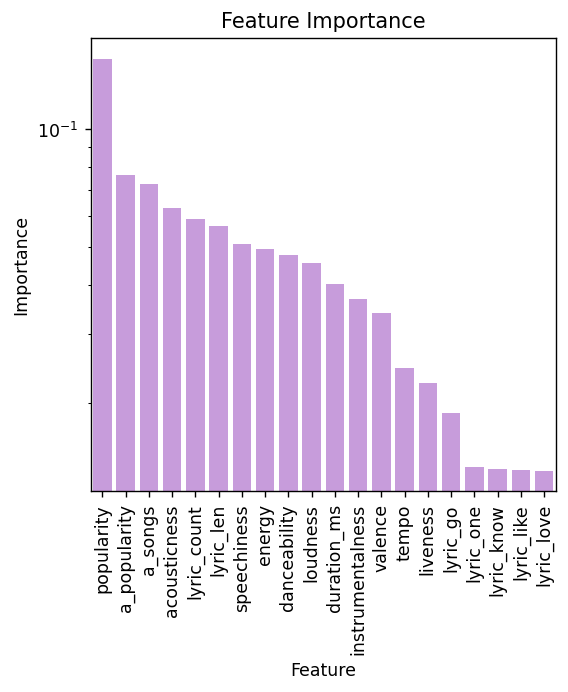

In [32]:
feature_importance = pd.DataFrame(columns = ['weight', 'feature'])
feature_importance['weight'] = modelo_tuneado.feature_importances_
feature_importance['feature'] = x_test_set.columns

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(dpi=125,figsize=(4.8, 4.8))
sns.barplot(data = feature_importance.sort_values(by = ['weight'], ascending = False).head(20), x = 'feature', y = 'weight', palette=['#cb92e5'])
plt.xticks(rotation = 90)
plt.yscale('log')
plt.title("Feature Importance")
plt.ylabel('Importance')
plt.xlabel('Feature')